In [1]:
from PIL.Image import *
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
import time
import itertools
import multiprocessing
import operator
from numpy import linalg as LA

In [2]:
list_dir=[]
list_shapes=[]
# we iterate over the folder fishes which contains the ct scan of each fish
root_adress="Fishes/"
for i in next(os.walk(root_adress))[1]:
    if i!=".ipynb_checkpoints":
        list_dir.append(root_adress+i)
list_dir=list_dir[:-1]
        
for i in list_dir:
    first_file=np.expand_dims(misc.imread(i+'/'+os.listdir(i)[0])[:,:,0],0)
    list_shapes.append(first_file.shape)
    print(first_file.shape)

# we get the minimum shape for each axis in order to put all the volume at the same scale (the minimum one)   
shapes0=[len(os.listdir(i)) for i in list_dir]    
min_shape0=min(shapes0)
min_shape1=min(list_shapes,key= lambda x:x[1])[1]
min_shape2=min(list_shapes,key= lambda x:x[2])[2]
print(min_shape0,min_shape1,min_shape2)


for it,repo in enumerate(list_dir):
    files_list=sorted(os.listdir(repo))
    files_list=[files_list[i] for i in range(len(files_list)) if i%int(shapes0[it]/min_shape0)==0]
    images_list=[np.expand_dims(misc.imread(repo+"/"+f)[:,:,0],0) for f in files_list]
    volume=np.concatenate(images_list)
    volume=volume[:,np.arange(0,volume.shape[1],int(volume.shape[1]/min_shape1)),:]
    volume=volume[:,:min_shape1,:]
    volume=volume[:,:,np.arange(0,volume.shape[2],int(volume.shape[2]/min_shape2))]
    volume=volume[:,:,:min_shape2]
    print(volume.shape)
    if it==0:
        whole_volume=volume
    else:
        whole_volume=np.concatenate((whole_volume,volume),axis=0)
volume=whole_volume.copy()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(1, 1286, 372)
(285, 1286, 372)
(285, 1286, 372)


In [3]:
# we downsample the whole volume
whole_volume=whole_volume[np.arange(0,whole_volume.shape[0],8),:,:]
whole_volume=whole_volume[:,np.arange(0,whole_volume.shape[1],8),:]
whole_volume=whole_volume[:,:,np.arange(0,whole_volume.shape[2],8)]

In [4]:
%load_ext Cython

In [5]:
%%cython
import numpy as np
cimport numpy as np
import itertools
import time

# return the indices of the adjacents vertices
def get_neighbors(int x, int y, int z,np.ndarray array,factor):
    index_list=[]
    cdef int i=0;
    cdef int j=0;
    cdef int k=0;
    cdef int shape0=array.shape[0]
    cdef int shape1=array.shape[1]
    cdef int shape2=array.shape[2]
    for i in range(x-factor,x+factor+1):
        if i>=0 and i<shape0:
            for j in range(y-factor,y+factor+1):
                if j>=0 and j<shape1:
                    for k in range(z-factor,z+factor+1):
                        if k>=0 and k<shape2:
                            if not(i==x and j==y and k==z):
                                index_list.append((i,j,k))
    return index_list

# return the upper link of a vertex (the neighbour which have a greater function than you)
cdef list upper_link(int x, int y, int z,np.ndarray array):
    cdef float value=array[x,y,z]
    index_list=[]
    cdef int i=0;
    cdef int j=0;
    cdef int k=0;
    cdef int shape0=array.shape[0]
    cdef int shape1=array.shape[1]
    cdef int shape2=array.shape[2]
    for i in range(x-1,x+2):
        if i>=0 and i<shape0:
            for j in range(y-1,y+2):
                if j>=0 and j<shape1:
                    for k in range(z-1,z+2):
                        if k>=0 and k<shape2:
                            if not(i==x and j==y and k==z):
                                if (i==x or j==y or k==z):
                                    if (array[i,j,k]>value):
                                        index_list.append([i,j,k])
                                    elif (array[i,j,k]==value):    
                                        if i>x:
                                            index_list.append([i,j,k])
                                        elif i==x:
                                            if j>y:
                                                index_list.append([i,j,k])
                                            elif j==y:
                                                if k>z:
                                                    index_list.append([i,j,k])

    return index_list

# return the value and the position of each cell of the array
cdef list get_indexes(np.ndarray array):
    cdef list indexes=[]
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            for k in range(0,array.shape[2]):
                indexes.append([array[i,j,k],[i,j,k]])
    return indexes    


# main function which computes the join tree
def hierarchical_segmentation(array):
    indexes=get_indexes(array)
    a=[d[0] for d in indexes]
    b=[d[1][0] for d in indexes]
    c=[d[1][1] for d in indexes]
    d=[d[1][2] for d in indexes]
#     sort the indexes by decreasing function value
    lala=np.lexsort((d,c,b,a))
    indexes=[[a[tmp],[b[tmp],c[tmp],d[tmp]]] for tmp in lala]
    indexes=indexes[::-1]
    topological_array=np.ones(array.shape)
    topological_propagate=np.ones(array.shape)
    topological_propagate[topological_propagate==1]=-1
    topological_array[topological_array==1]=-1
    count=0
    maximum_set=set()
    parent_dict={}
    cdef int i=0;
    print("Entering the loop")
    for i in range(len(indexes)):
        value=indexes[i][0]
        a=indexes[i][1][0]
        b=indexes[i][1][1]
        c=indexes[i][1][2]
        
#         for each vertex, we compute the upper link
        index_list=upper_link(a,b,c,array)
        tmp=[topological_propagate[tmp[0],tmp[1],tmp[2]] for tmp in index_list]
        dict_key=set(tmp)
#         if it's empty the we create a new component
        if len(dict_key)==0:
            topological_array[a,b,c]=count
            topological_propagate[a,b,c]=count
            maximum_set.add(count)
            count+=1
#         if if only contains one component (regular point) then we add the point to the existing component
#         we don't create a new one
        elif len(dict_key)==1:
            topological_array[a,b,c]=topological_propagate[index_list[0][0],index_list[0][1],index_list[0][2]]
            topological_propagate[a,b,c]=topological_propagate[index_list[0][0],index_list[0][1],index_list[0][2]]
#         if the upper link contains more than two components then, we create a new one which englobes all the neighbours one
        else:        
            topological_propagate[a,b,c]=count
            topological_array[a,b,c]=count
            for j in dict_key:
                parent_dict[j]=count
                topological_propagate[topological_propagate==j]=count
            count+=1
    return topological_array,maximum_set,parent_dict

In [6]:
# how we mesure a component
def set_w(a,topological_array,x,inverse_dict):
    volume=float(np.sum(a[topological_array==x]))
    return volume

# for each component of the tree we compute w
def compute_w(a,topological_array,inverse_dict):
    w={}
    for i in np.unique(topological_array):
        w[i]=set_w(a,topological_array,i,inverse_dict)
    return w

# for all the components in the maximum set, we add the maximum component and his parent to the 
# list of the cylinder to remove
def compute_sorted_x(maximum_set,w,parent_dict,topological_array,a):
    sorted_x=[]
    for i in maximum_set:
        sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)
    return sorted_x

# compute the 
def compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a):
    if i in parent_dict:
        j=parent_dict[i]
        if i in w and j in w:
                sorted_x.append(((i,j),w[i],np.sum(np.abs(np.mean(np.argwhere(topological_array==i),axis=0)-np.mean(np.argwhere(topological_array==j),axis=0)))))
    return sorted_x

# remove one branch from the join tree
def single_tree_simplification(w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict,array):
#     we sort all the maximum components we can remove
    tmp1=[i[1] for i in sorted_x]
    tmp2=[i[2] for i in sorted_x]
    lala=np.lexsort((tmp2,tmp1))
#     we delete the smallest one
    maximum,saddle=sorted_x[lala[0]][0]
    if maximum in maximum_set:
        regular_2_list=[maximum]
        maximum_set.remove(maximum)
        #we replace all the place where this maximum component appears by his saddle parent
        topological_array[topological_array==maximum]=saddle
        #we compute the new value of the saddle
        w[saddle]=set_w(a,topological_array,saddle,inverse_dict)
        i=saddle
        intersection=[(topological_array==j).sum() for j in inverse_dict[i]]
        intersection_sum=np.count_nonzero(intersection)
        #if his parent doesn't have any child anymore, then we put this saddle as a maximum
        if intersection_sum==0:
            maximum_set.add(i)
            sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)
        #if his parent only have on child anymore, then we merge his child with it and put it as a maximum
        elif intersection_sum==1:
            old_maximum=[j for j in inverse_dict[i] if ((topological_array==j).sum()!=0)][0]
            if old_maximum in maximum_set:
                maximum_set.remove(old_maximum)
                topological_array[topological_array==old_maximum]=i
                w[i]=set_w(a,topological_array,i,inverse_dict)
                regular_2_list.append(old_maximum)
                maximum_set.add(i)
                sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)                
                
    sorted_x.pop(lala[0])
    return w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict

In [7]:
a=whole_volume
time1=time.time()
# we compute the join tree
topological_array,maximum_set,parent_dict=hierarchical_segmentation(a)
time2=time.time()
print(time2-time1)
inverse_dict={}
for i in parent_dict:
    if parent_dict[i] not in inverse_dict:
        inverse_dict[parent_dict[i]]=set([i])
    else:
        inverse_dict[parent_dict[i]].add(i)
# compute the measure of each component
w=compute_w(a,topological_array,inverse_dict)
# add in a list all the maximum component that can be merged with their respective parent
sorted_x=compute_sorted_x(maximum_set,w,parent_dict,topological_array,a)

Entering the loop
25.0341529846


('Number of unique values :', 18895, '- Number of maximum left ', 9412)
('Number of unique values :', 18793, '- Number of maximum left ', 9316)
('Number of unique values :', 18694, '- Number of maximum left ', 9217)
('Number of unique values :', 18598, '- Number of maximum left ', 9127)
('Number of unique values :', 18501, '- Number of maximum left ', 9030)
('Number of unique values :', 18405, '- Number of maximum left ', 8937)
('Number of unique values :', 18310, '- Number of maximum left ', 8847)
('Number of unique values :', 18201, '- Number of maximum left ', 8752)
('Number of unique values :', 18080, '- Number of maximum left ', 8654)
('Number of unique values :', 17960, '- Number of maximum left ', 8560)
('Number of unique values :', 17860, '- Number of maximum left ', 8460)
('Number of unique values :', 17752, '- Number of maximum left ', 8361)
('Number of unique values :', 17624, '- Number of maximum left ', 8274)
('Number of unique values :', 17521, '- Number of maximum left '

KeyboardInterrupt: 

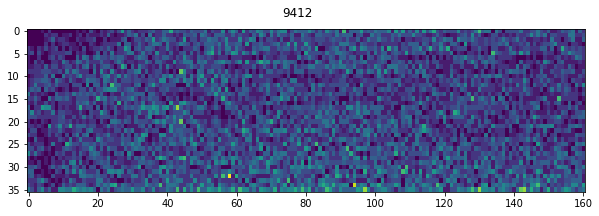

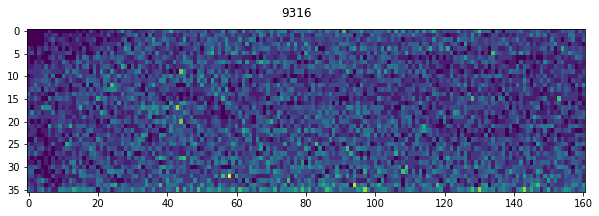

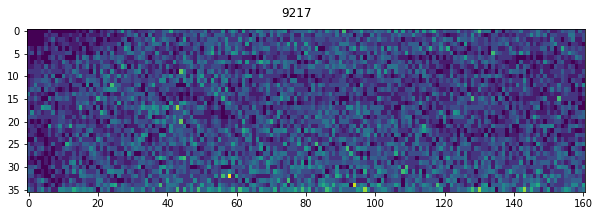

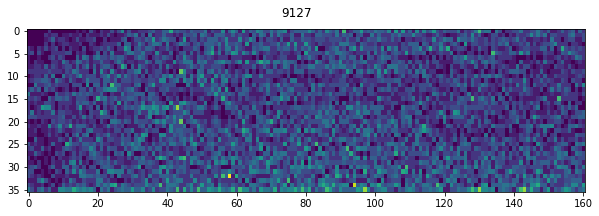

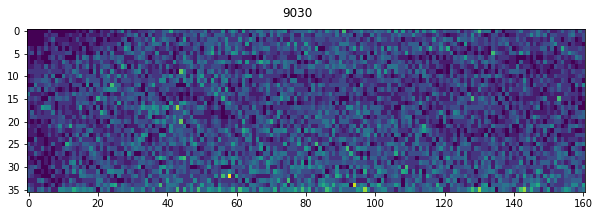

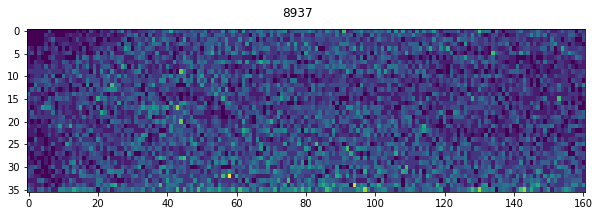

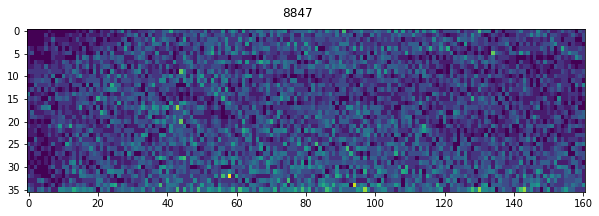

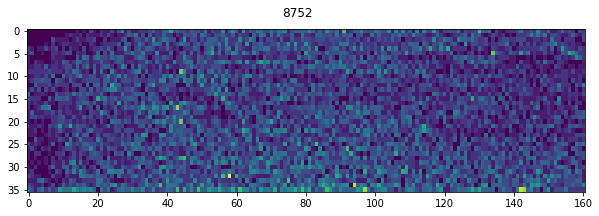

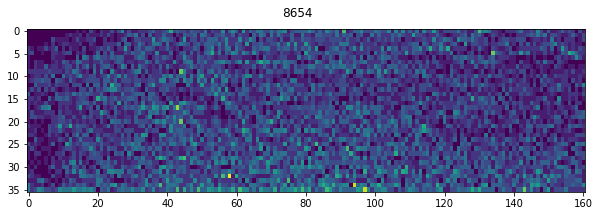

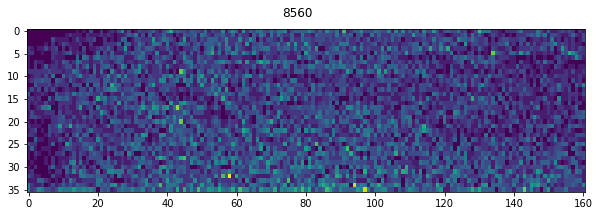

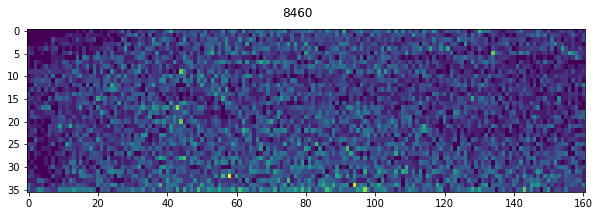

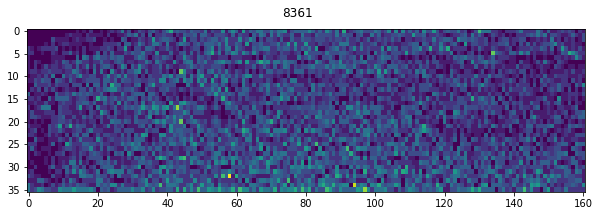

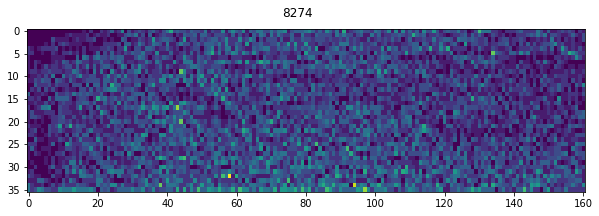

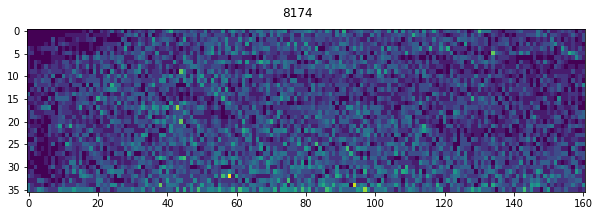

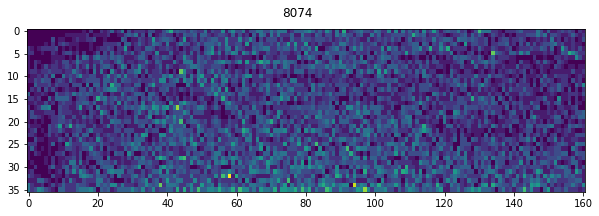

In [10]:
count=0
n=2
display_set=set([])
# until n-1 branches are left
while len(np.unique(topological_array))>2 and len(maximum_set)>n-1:
# while count<10:
    lala=topological_array.copy()
    w_save=w.copy()
    max_save=maximum_set.copy()
#     we remove some branch at each time
    w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict=single_tree_simplification(w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict,a)
    count+=1
    if count%100==0 :
        print("Number of unique values",len(np.unique(topological_array)),"Number of maximum left",len(maximum_set))

    
        display_set.add(len(maximum_set))

        #display the segmentation
        bb=np.zeros(topological_array.shape)
        for i in range(topological_array.shape[0]):
            for j in range(topological_array.shape[1]):
                for k in range(topological_array.shape[2]):
                    if topological_array[i,j,k] in maximum_set:
                        bb[i,j,k]=1
        fig, ax = plt.subplots(figsize=(10,3))
        fig.suptitle(len(maximum_set))
        ax.imshow(np.mean(bb,axis=-1),aspect="auto",)

print("Max Nb ",len(maximum_set))
print("Unique Nb ",len(np.unique(topological_array)))

In [ ]:
# we display the branches that are left
for i in max_save:
    print(i)
    q=np.zeros(topological_array.shape)
    q[lala==i]=1
    fig, ax = plt.subplots(figsize=(10,3))
    ax.imshow(np.mean(q,axis=-1),aspect="auto")